# **Data from Muyong**
! pip install xlrd
## **1 sheet Names**
엑셀내 시트내용 살펴보기

In [1]:
import xlrd, re
xls = xlrd.open_workbook(r'backup/menuDatas2003.xls', on_demand=True)
sheetName = xls.sheet_names()
print(sheetName[:5])

from tqdm import tqdm
shtList = []
for _ in tqdm(sheetName):
    chk = re.findall(r"(\d+).(\d+)[-.](\d+)",_)
    if chk:
        if len("".join(chk[0])) < 5: print(_)
        else: shtList.append(_)
    else: print(_)
        
len(shtList)

100%|██████████| 253/253 [00:00<00:00, 170385.18it/s]

['업체별단가 및 사모님이 사오시는 품목', '사용량', '18년1.16-24', '18년2.20-', '18.03.20']
업체별단가 및 사모님이 사오시는 품목
사용량


251

## **2 import from Sheet**
엑셀내 시트내용 살펴보기

In [2]:
# merge cell 때문에 전체가 보이질 않는다 ㅠㅠ..
import pandas as pd
pd.read_excel('backup/menuDatas2003.xls', sheetName=shtList[5]).head(2)

,품명,신용축산,비앤피,사모님이 사오시는품목
0,NaN,031 426 8833,010 3805 4938,NaN
1,목전지(제육),4800,4700,굴소스


# **Recipe 요약하기**
1. token 의 추출
1. 유사한 메뉴끼리 묶는다
## **1 sheet Names**
엑셀내 시트내용 살펴보기

In [1]:
import pandas as pd
menus = pd.read_csv('data/muyong_menus.csv', encoding='ms949')
menus = menus.dropna(subset=['메인1', '메인2'])
menus.head(2)

,년도,주차,요일,구분,메인1,메인2,메인3,메인4,메인5,메인6,메인7,메인8,메인9,메인10,Unnamed: 14
1,2017,52,화,중식,황태미역국,매콤제육볶음,해물볶음우동,팽이맛살계란전,양상추샐러드,흑임자D,치커리사과겉절이,양념깻잎지,포기김치,NaN,NaN
2,2017,52,수,중식,육개장,사천식칠리탕수육,카레라이스,멸치꽈리볶음,사과단감샐러드,훈제오리야채겨자무침,콩나물매콤무침,포기김치,NaN,NaN,NaN


In [2]:
# DataFrame 에서 Token 추출하기
result = []
for _ in menus.columns[4:]:
    result += menus[_].values.tolist()

# Token List 에서 유효단어만 추출
temp = []
for i, _ in enumerate(result):
    try:
        temp.append(" ".join(re.findall(r"\w+", _)))
    except: pass

result = " ".join(temp) # 유효메뉴값 20000 개

# **word piece model 로 유효값 높은 Token 추출하기**
## **1 단어 Token 들 중복 수집하기**

In [5]:
# result 단어 중 중복 갯수들 묶어보기
tokens = result.split(' ')
tokens = list(set(tokens))
tokenText = ' '.join(tokens)

from konlpy.tag import Okt
# Okt().pos("한겨레나눔백반볶음밥")
tokenWords = Okt().morphs(tokenText)
len(tokens), len(tokenWords)

/home/markbaum/Python/nltk/lib/python3.6/site-packages/jpype/_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


(2903, 8965)

# **작업의 Plan**
1. 음절로 token 을 나눈 뒤, 2, 3 Token 중 가치높은 묶음 찾기
1. 유효값은 5개, 4개, 3개, 2개 순서로 작업
1. **유효값이 큰 내용** 부터 추린 후, **작은 값에는 새로운 값만** 추출하며 유효값 찾기

In [6]:
# 요리 카테고리로 자료가 묶임
# 국, 밥, 
# 육
# 조림, 튀김, 샐러드, 무침, 볶음, 잡채
# 소스

# QutaGram ~ UniGram 순서대로 유효값 찾기
# 결과값은 휴리스틱으로 유용한 결과값 찾기
# 1. 무 국 밥

## **1 유용한 음절 찾기**
1. 유효한 음절은 **꼭 1개의 의미만** 포함해야 한다 (규칙!!)
1. 2개 이상 포함되지 않도록 기준 단어를 작업해야 한다
1 **5개** 는 유효값이 1개가 아니어서 Pass
1. **4개 ~ 1개** 까지 **휴리스틱 방식** 으로 자료 찾기

In [7]:
%matplotlib inline
from matplotlib import rc, rcParams
import matplotlib.pyplot as plt
rc('font', family=['NanumGothic','Malgun Gothic']) # 한글의 표시
rcParams['axes.unicode_minus'] = False             # '-' 표시의 처리

# token 을 어절로 구분
def ngram(token, n):
    return [token[_: _+n] for _ in range(0, (len(token)-n+1))]

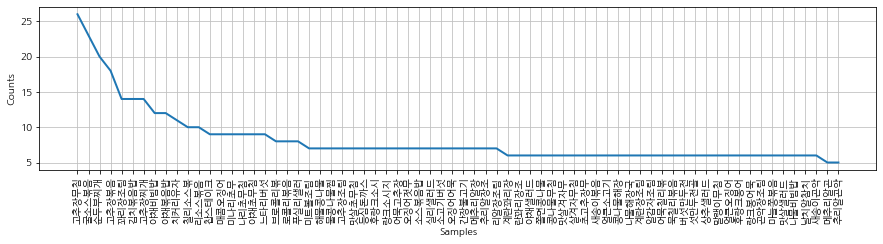

In [8]:
# N-Gram 유용한 값 찾기
n_gram    = 5
tokeNgram = []
for _ in tokens:
    tokeNgram += ngram(_, n_gram)

from nltk import Text
ngramObj = Text(tokeNgram)   # [list] 객체로 Text 생성
plt.figure(figsize=(15, 3))  # 파레트 설정
ngramObj.plot(70)

## **2 QutaGram 유용한 음절 찾기**
**4개 ~ 1개** 까지 **휴리스틱 방식** 으로 자료 찾기

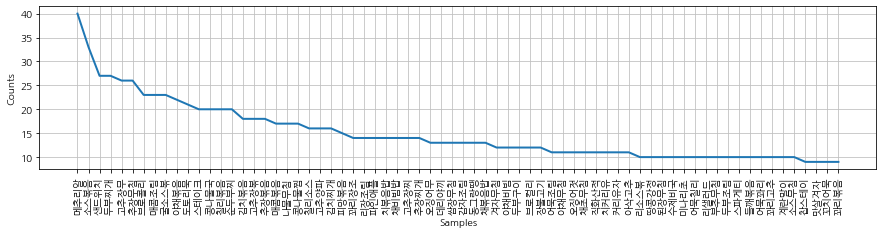

In [9]:
# N-Gram 유용한 값 찾기
n_gram    = 4
tokeNgram = []
for _ in tokens:
    tokeNgram += ngram(_, n_gram)

from nltk import Text
ngramObj = Text(tokeNgram)   # [list] 객체로 Text 생성
plt.figure(figsize=(15, 3))  # 파레트 설정
ngramObj.plot(70)

In [10]:
# ngramComm = [_[0]  for _ in ngramObj.vocab().most_common(400)]
# ngramComm
ngramObj.vocab().most_common(400)

[('메추리알', 40),
 ('소스볶음', 33),
 ('샌드위치', 27),
 ('두부찌개', 27),
 ('고추장무', 26),
 ('추장무침', 26),
 ('브로콜리', 23),
 ('매콤조림', 23),
 ('굴소스볶', 23),
 ('야채볶음', 22),
 ('도토리묵', 21),
 ('스테이크', 20),
 ('콩나물국', 20),
 ('칠리볶음', 20),
 ('순두부찌', 20),
 ('김치볶음', 18),
 ('고추장볶', 18),
 ('추장볶음', 18),
 ('매콤볶음', 17),
 ('나물무침', 17),
 ('콩나물찜', 17),
 ('칠리소스', 16),
 ('고추양파', 16),
 ('김치찌개', 16),
 ('피망볶음', 15),
 ('꽈리장조', 14),
 ('리장조림', 14),
 ('파인애플', 14),
 ('치볶음밥', 14),
 ('채비빔밥', 14),
 ('고추장찌', 14),
 ('추장찌개', 14),
 ('오징어무', 13),
 ('데리야끼', 13),
 ('쌈장무침', 13),
 ('감자조림', 13),
 ('동그랑땡', 13),
 ('채볶음밥', 13),
 ('겨자무침', 12),
 ('야채비빔', 12),
 ('두부구이', 12),
 ('브로컬리', 12),
 ('장불고기', 12),
 ('어묵조림', 11),
 ('야채무침', 11),
 ('오징어젓', 11),
 ('채초무침', 11),
 ('직화산적', 11),
 ('치커리유', 11),
 ('커리유자', 11),
 ('아삭고추', 11),
 ('리소스볶', 10),
 ('땅콩강정', 10),
 ('된장무침', 10),
 ('수제비국', 10),
 ('미나리초', 10),
 ('어묵칠리', 10),
 ('리샐러드', 10),
 ('부추무침', 10),
 ('두부조림', 10),
 ('스파게티', 10),
 ('들깨볶음', 10),
 ('어묵꽈리', 10),
 ('꽈리고추', 10),
 ('계란말이', 10),
 ('소스무침', 10),
 ('찹스테이', 

In [11]:
ngramComm = [_[0]  for _ in ngramObj.vocab().most_common(400)]
" ".join(list(sorted(ngramComm)))

'가루무침 가쓰오국 간장불고 갈비떡찜 갈비산적 갈비조림 감자고로 감자고추 감자수제 감자조림 감자튀김 강정소스 건파래실 게맛살초 겨자무침 계란꽈리 계란말이 계란야채 계란장조 고기두부 고기버섯 고기볶음 고기우거 고기콩나 고로케튀 고추무침 고추쌈장 고추양파 고추장떡 고추장무 고추장볶 고추장조 고추장찌 곤약장조 골우거지 구이양념 굴소스볶 그랑땡전 그랑떙전 기우거지 기콩나물 김가루무 김치겉절 김치두부 김치볶음 김치순두 김치찌개 깻순볶음 깻잎볶음 꼬치어묵 꽃게해물 꽈리고추 꽈리볶음 꽈리장조 나리초무 나메추리 나물무침 나물볶음 나물비빔 나물생채 나물해장 날도시락 날소시지 날치알김 날치알참 너비아니 느타리버 늘쫑볶음 닭가슴살 데리야끼 도라지오 도토리묵 돈사태떡 돈사태찜 돈육고추 돈육김치 돈육깐풍 돈육버섯 돈육숙주 돈육탕수 돈채피망 동겉절이 동그랑땡 동그랑떙 된장무침 된장찌개 두루치기 두부구이 두부매콤 두부조림 두부찌개 들깨무침 들깨볶음 등갈비찜 등심돈까 땅콩강정 땅콩볶음 땅콩조림 땅콩콩조 라살새송 라지오이 란꽈리장 란야채볶 란장조림 랑크봉어 랑크브로 랑크소시 랭이무침 로컬리볶 로케튀김 로콜리볶 리고추장 리샐러드 리소스볶 리알곤약 리알새송 리알샐러 리알장조 리유자청 리장조림 리초무침 마늘쫑볶 마카로니 마파두부 만두계란 만두전골 만두튀김 말랭이무 맛살겨자 맛살계란 맛살볶음 맛살브로 맛살샐러 맛살초무 매콤강정 매콤등갈 매콤무침 매콤볶음 매콤어묵 매콤오징 매콤제육 매콤조림 메추리알 면콩나물 멸치볶음 무말랭이 무미나리 무식오징 무쌈말이 묵고추장 묵칠리볶 물동그랑 물비빔밥 물순두부 물콩나물 물해장국 미나리초 미소장국 미역오이 미역줄기 미트볼볼 미트볼조 바베큐소 박고추장 박스테이 배추김치 버섯만두 버섯볶음 버섯잡채 버섯찌개 버섯탕수 베큐소스 볶음우동 볼볼어묵 봉어묵칠 부구이양 부대찌개 부매콤조 부추고추 부추무침 부추장떡 부팽이가 브로컬리 브로콜리 비빔국수 비엔나메 비엔나칠 사각어묵 사골우거 산적구이 산적매콤 살겨자무 살브로콜 살새송이 살샐러드 살참나물 살초무침 상추샐러 새송이곤 새송이버